# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [64]:
! pip install Pillow

In [65]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision
import torch.nn.functional as F

## Carregamento dos dados do MNIST

In [66]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [67]:
!ls MNIST

processed  raw


In [68]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [69]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

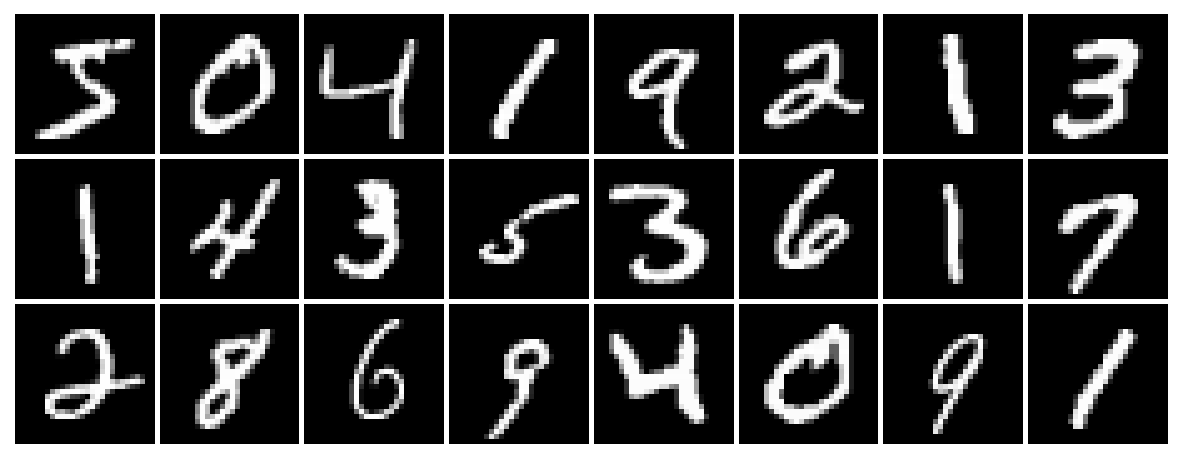

In [70]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


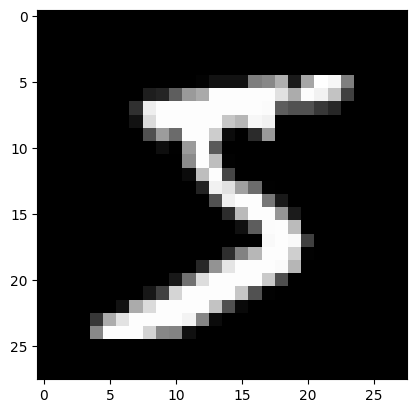

In [71]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

In [72]:
image

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

## Modelo

In [73]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida (de 0 a 9)

In [74]:
#Parametros: 28*28*10+10(de bias)=7850

### Testando um predict com poucas amostras

In [75]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.2832, -0.2072,  0.3548, -0.1413, -0.1250, -0.1904, -0.1441, -0.3035,
         -0.0125,  0.1904],
        [ 0.2709, -0.3802,  0.3233, -0.0688,  0.1696, -0.3492, -0.2841, -0.2247,
          0.0233, -0.2612],
        [ 0.0499, -0.0308, -0.0125,  0.0073,  0.0632, -0.2260, -0.0104, -0.3099,
          0.0143,  0.1028],
        [-0.0780,  0.1333,  0.2081,  0.2273,  0.0692, -0.1920, -0.1096, -0.2134,
          0.0869,  0.1348],
        [ 0.2094,  0.1897,  0.0725,  0.3462,  0.0055, -0.3428, -0.1265, -0.0638,
          0.3534,  0.1392]], grad_fn=<AddmmBackward0>)

In [76]:
xin

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [77]:
#Retorna a probabilidade em %
F.softmax(score,dim=1)*100


tensor([[13.3472,  8.1734, 14.3384,  8.7306,  8.8737,  8.3123,  8.7063,  7.4235,
          9.9307, 12.1639],
        [13.7366,  7.1627, 14.4744,  9.7795, 12.4130,  7.3887,  7.8857,  8.3676,
         10.7235,  8.0682],
        [10.8092,  9.9716, 10.1554, 10.3589, 10.9538,  8.2031, 10.1772,  7.5427,
         10.4318, 11.3963],
        [ 8.9026, 10.9964, 11.8514, 12.0803, 10.3140,  7.9430,  8.6251,  7.7750,
         10.4983, 11.0138],
        [11.1697, 10.9515,  9.7399, 12.8066,  9.1088,  6.4299,  7.9823,  8.4995,
         12.8992, 10.4126]], grad_fn=<MulBackward0>)

In [78]:
torch.max(F.softmax(score,dim=1)*100)

tensor(14.4744, grad_fn=<MaxBackward1>)

## Treinamento

### Inicialização dos parâmetros

In [79]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [80]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-e0v96xfu
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-e0v96xfu
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done


In [81]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.2970, grad_fn=<NllLossBackward0>)

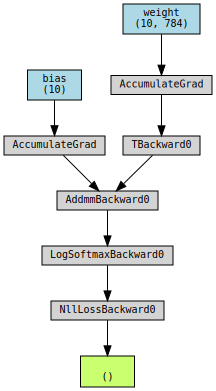

In [82]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [83]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9 - Score
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [84]:
print('Final loss:', loss.item())

Final loss: 0.26488128304481506


### Visualizando gráfico de perda durante o treinamento

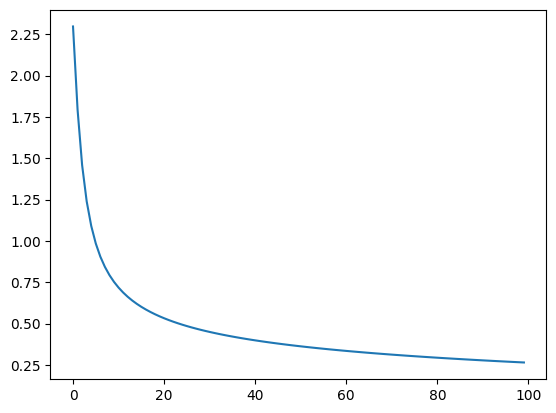

In [85]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [86]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.939


### Matriz de confusão com dados de treinamento e teste

In [87]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,3,1,0
2,0,1,90,1,0,1,0,1,2,1
3,0,0,0,87,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,2,0,82,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,2,1,0,0,0,110,0,3
8,0,2,2,0,0,1,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


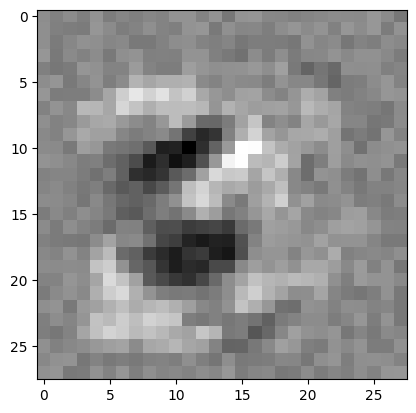

In [88]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

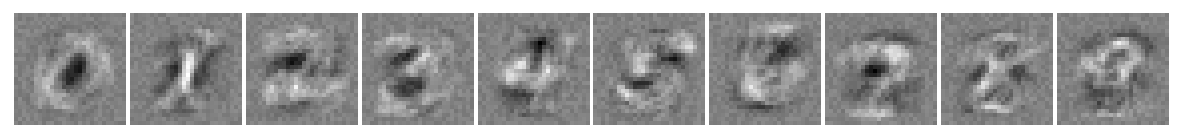

In [89]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

A época: 1/100, tem perda de 0.13400979340076447 e acurácia de: 0.979


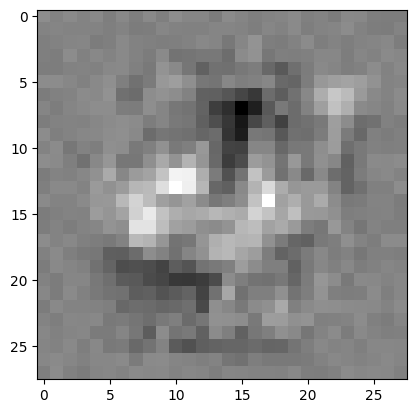

A época: 2/100, tem perda de 0.13367193937301636 e acurácia de: 0.979


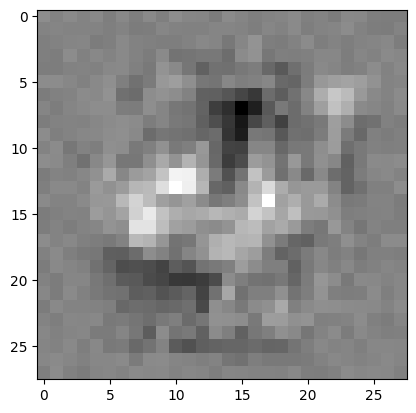

A época: 3/100, tem perda de 0.13333562016487122 e acurácia de: 0.979


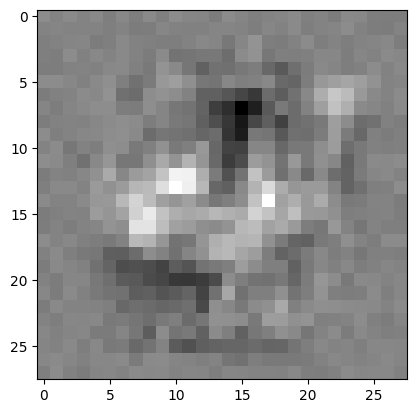

A época: 4/100, tem perda de 0.13300083577632904 e acurácia de: 0.98


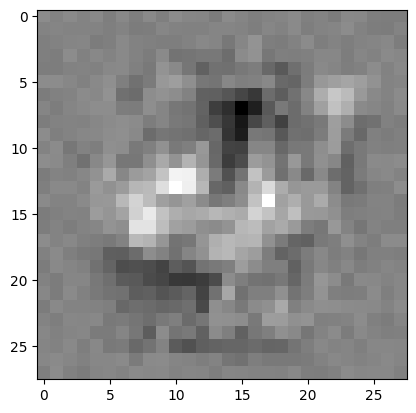

A época: 5/100, tem perda de 0.13266752660274506 e acurácia de: 0.98


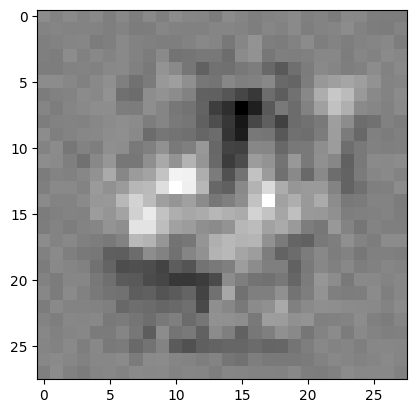

A época: 6/100, tem perda de 0.13233575224876404 e acurácia de: 0.98


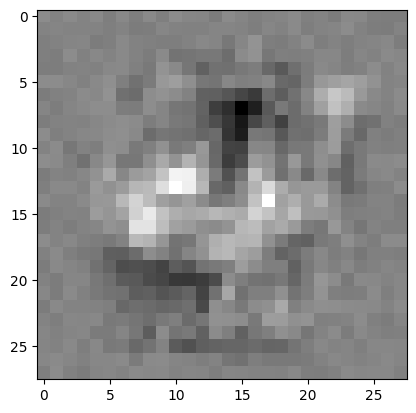

A época: 7/100, tem perda de 0.1320054680109024 e acurácia de: 0.98


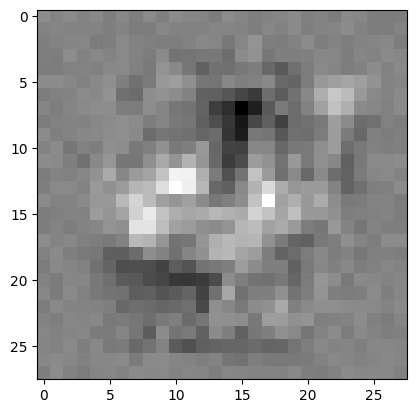

A época: 8/100, tem perda de 0.13167664408683777 e acurácia de: 0.98


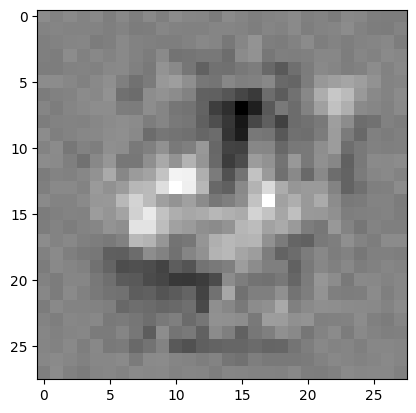

A época: 9/100, tem perda de 0.1313493251800537 e acurácia de: 0.98


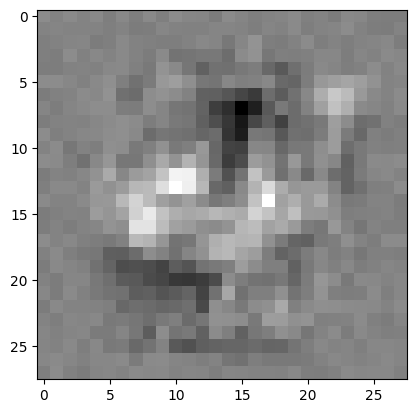

A época: 10/100, tem perda de 0.13102343678474426 e acurácia de: 0.98


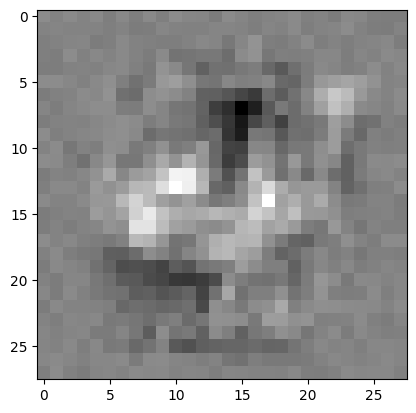

A época: 11/100, tem perda de 0.130699023604393 e acurácia de: 0.98


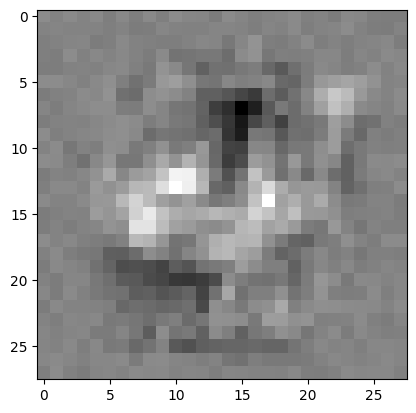

A época: 12/100, tem perda de 0.13037605583667755 e acurácia de: 0.98


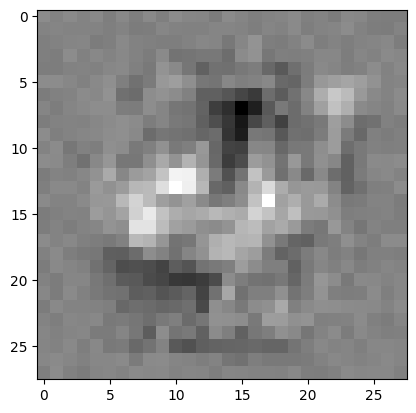

A época: 13/100, tem perda de 0.1300545036792755 e acurácia de: 0.98


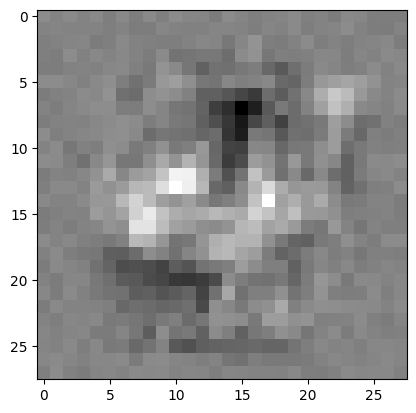

A época: 14/100, tem perda de 0.12973441183567047 e acurácia de: 0.98


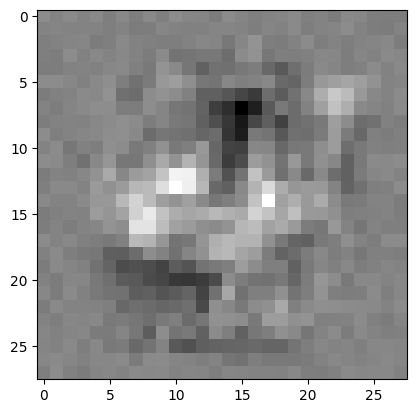

A época: 15/100, tem perda de 0.12941569089889526 e acurácia de: 0.98


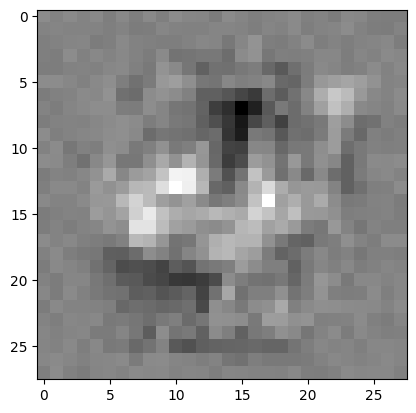

A época: 16/100, tem perda de 0.12909840047359467 e acurácia de: 0.98


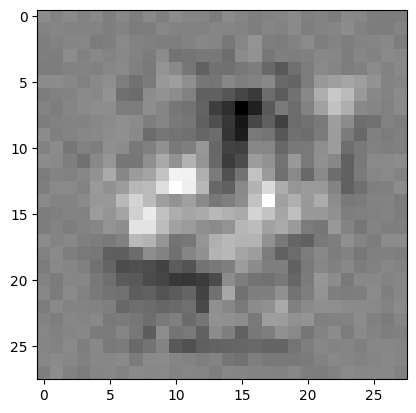

A época: 17/100, tem perda de 0.1287825107574463 e acurácia de: 0.98


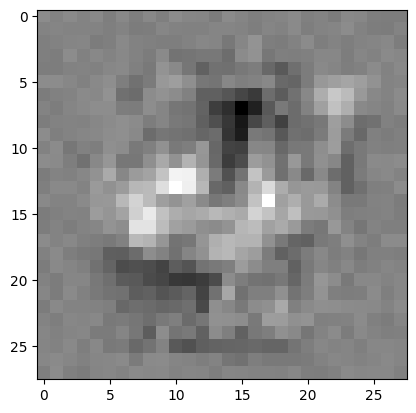

A época: 18/100, tem perda de 0.12846800684928894 e acurácia de: 0.98


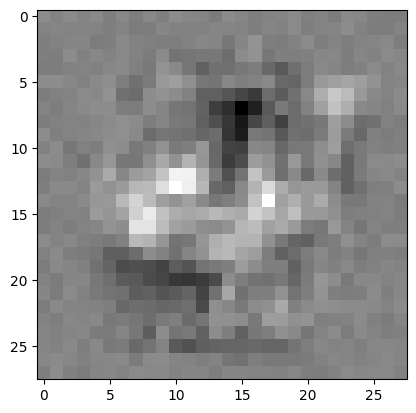

A época: 19/100, tem perda de 0.12815485894680023 e acurácia de: 0.98


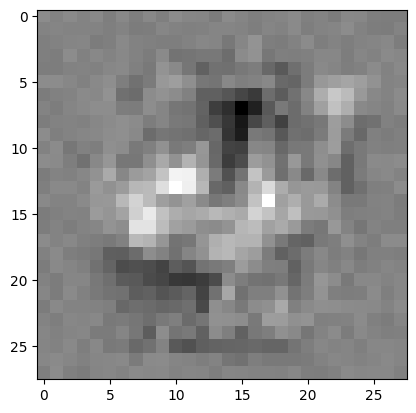

A época: 20/100, tem perda de 0.12784311175346375 e acurácia de: 0.98


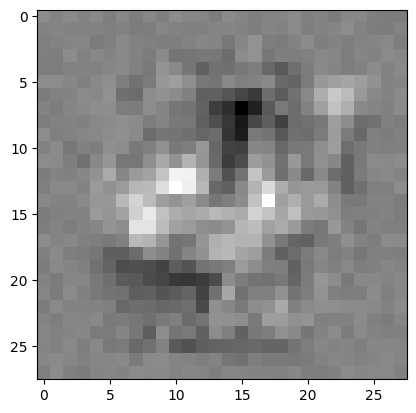

A época: 21/100, tem perda de 0.1275327205657959 e acurácia de: 0.98


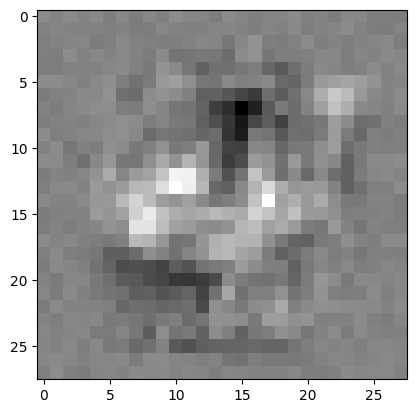

A época: 22/100, tem perda de 0.1272236704826355 e acurácia de: 0.981


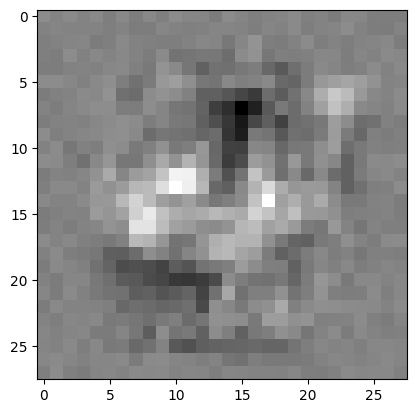

A época: 23/100, tem perda de 0.12691599130630493 e acurácia de: 0.981


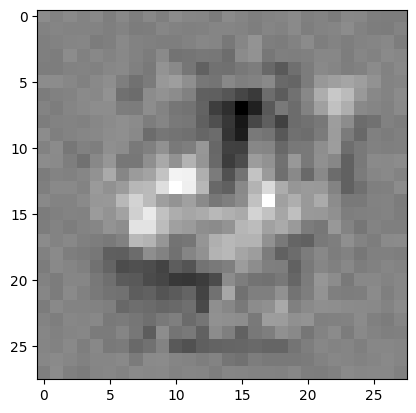

A época: 24/100, tem perda de 0.12660960853099823 e acurácia de: 0.981


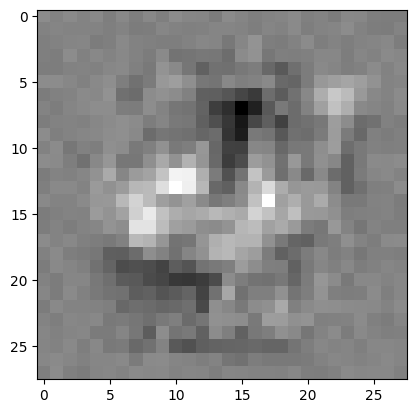

A época: 25/100, tem perda de 0.12630456686019897 e acurácia de: 0.982


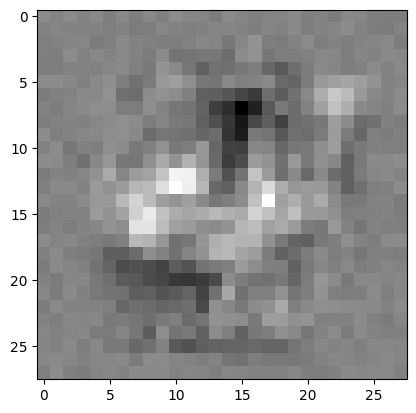

A época: 26/100, tem perda de 0.12600086629390717 e acurácia de: 0.982


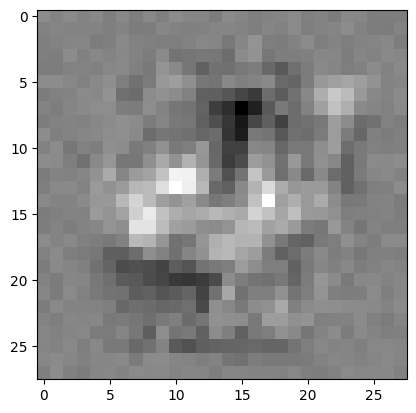

A época: 27/100, tem perda de 0.12569846212863922 e acurácia de: 0.982


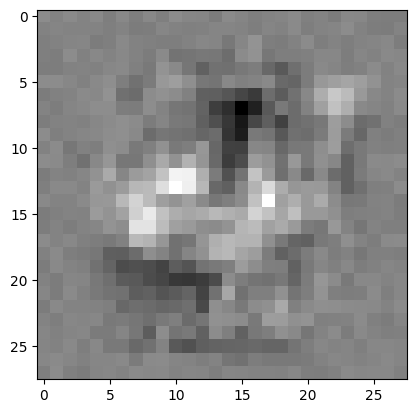

A época: 28/100, tem perda de 0.12539733946323395 e acurácia de: 0.983


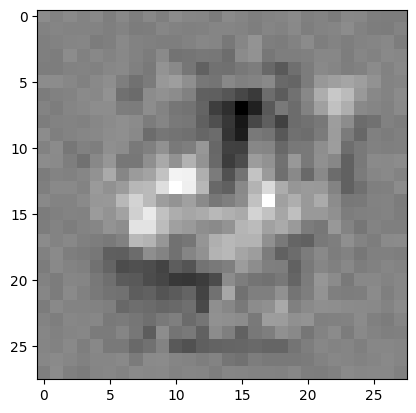

A época: 29/100, tem perda de 0.12509754300117493 e acurácia de: 0.983


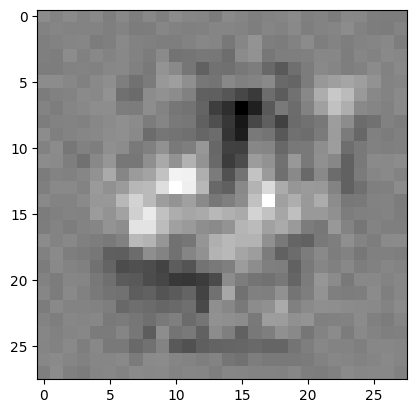

A época: 30/100, tem perda de 0.12479899823665619 e acurácia de: 0.983


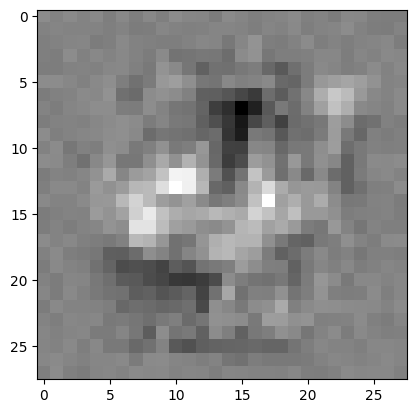

A época: 31/100, tem perda de 0.1245017796754837 e acurácia de: 0.983


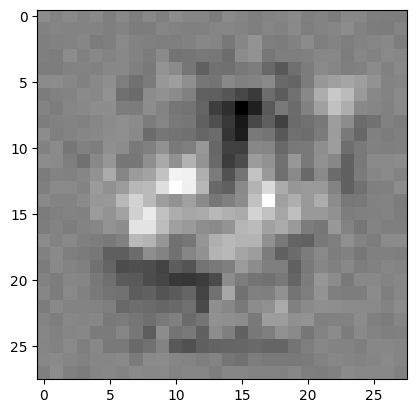

A época: 32/100, tem perda de 0.12420579046010971 e acurácia de: 0.983


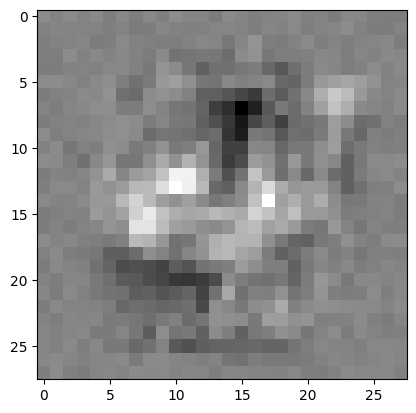

A época: 33/100, tem perda de 0.1239110678434372 e acurácia de: 0.983


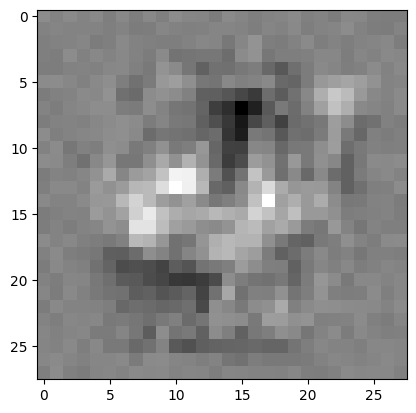

A época: 34/100, tem perda de 0.12361760437488556 e acurácia de: 0.983


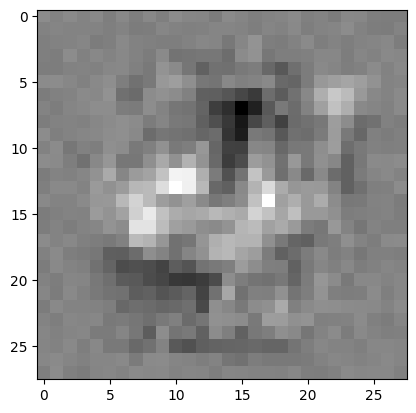

A época: 35/100, tem perda de 0.12332538515329361 e acurácia de: 0.983


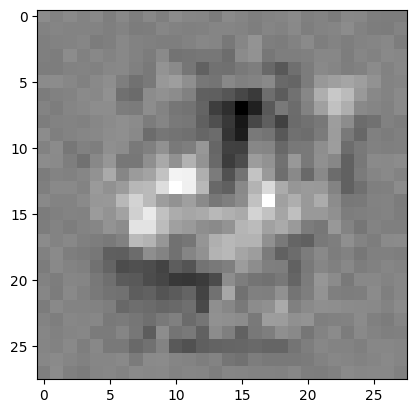

A época: 36/100, tem perda de 0.12303442507982254 e acurácia de: 0.983


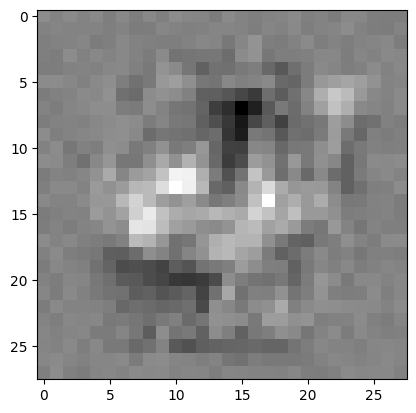

A época: 37/100, tem perda de 0.12274467945098877 e acurácia de: 0.983


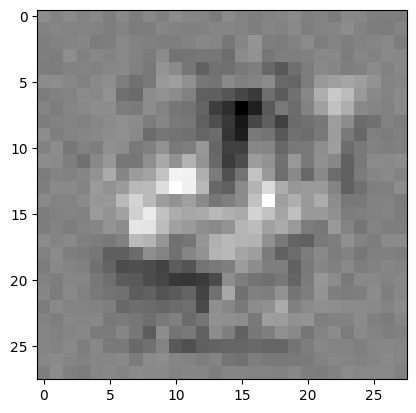

A época: 38/100, tem perda de 0.1224561482667923 e acurácia de: 0.983


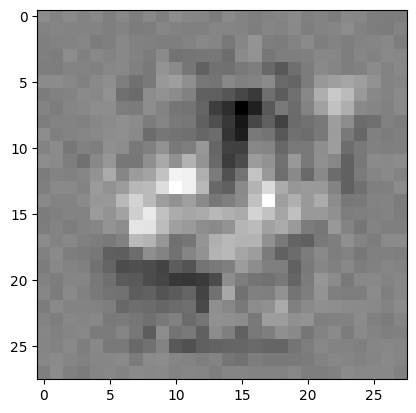

A época: 39/100, tem perda de 0.12216886132955551 e acurácia de: 0.983


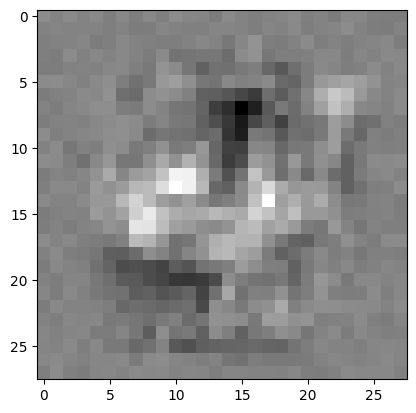

A época: 40/100, tem perda de 0.12188275158405304 e acurácia de: 0.984


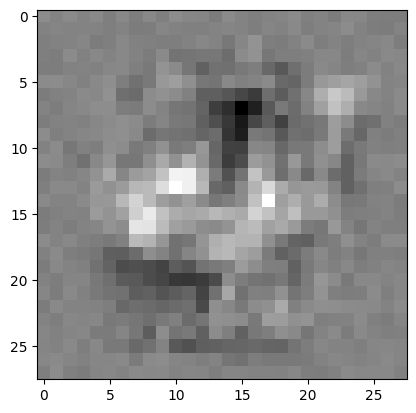

A época: 41/100, tem perda de 0.12159786373376846 e acurácia de: 0.984


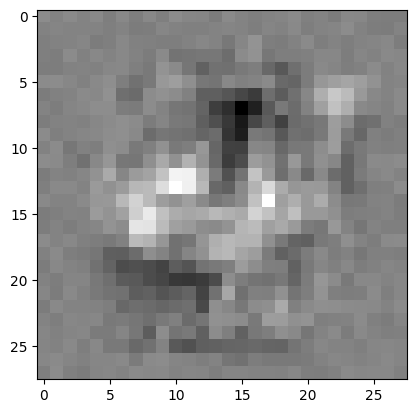

A época: 42/100, tem perda de 0.1213141605257988 e acurácia de: 0.984


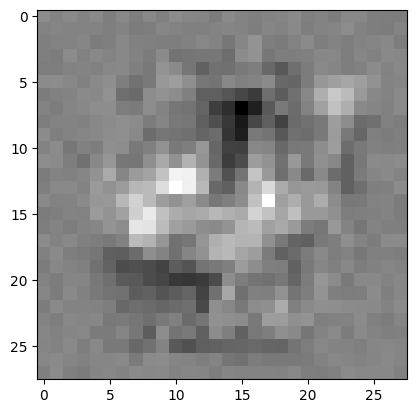

A época: 43/100, tem perda de 0.12103163450956345 e acurácia de: 0.984


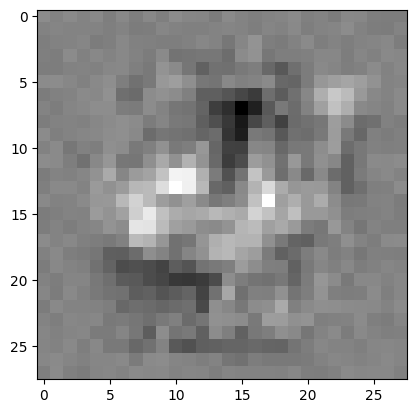

A época: 44/100, tem perda de 0.1207503154873848 e acurácia de: 0.984


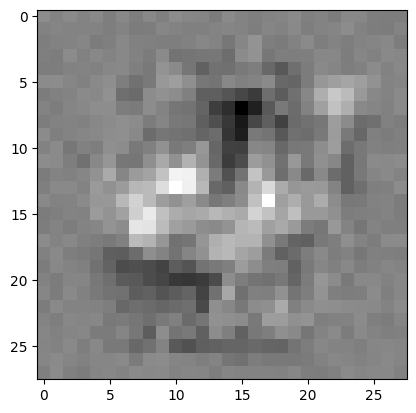

A época: 45/100, tem perda de 0.12047015130519867 e acurácia de: 0.984


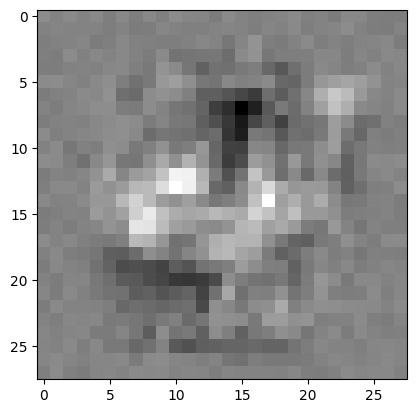

A época: 46/100, tem perda de 0.12019114941358566 e acurácia de: 0.984


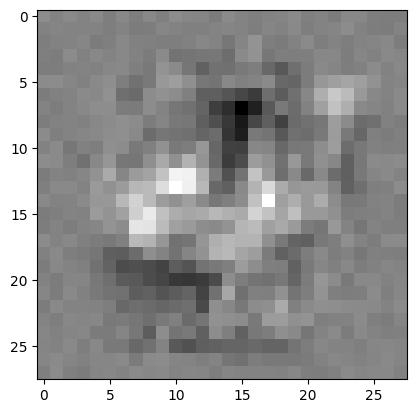

A época: 47/100, tem perda de 0.11991330236196518 e acurácia de: 0.984


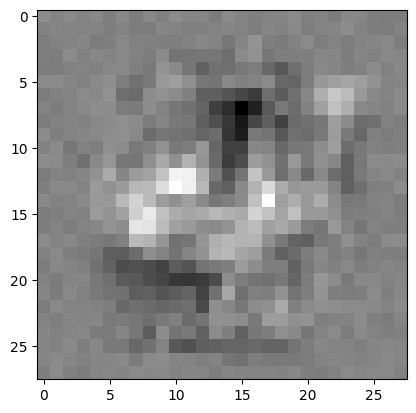

A época: 48/100, tem perda de 0.11963661760091782 e acurácia de: 0.984


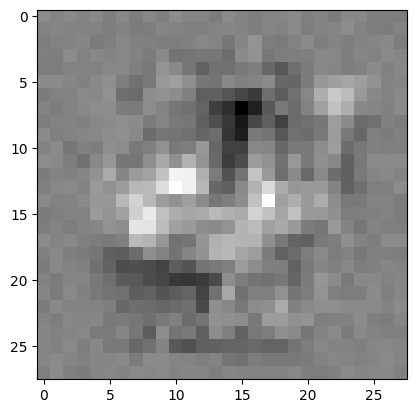

A época: 49/100, tem perda de 0.11936107277870178 e acurácia de: 0.984


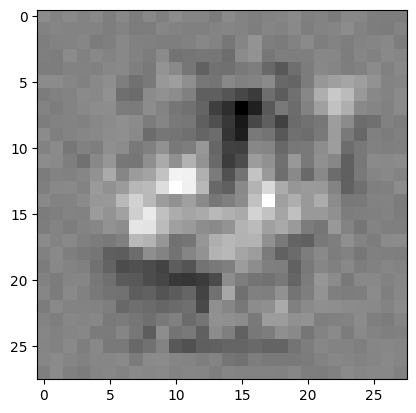

A época: 50/100, tem perda de 0.11908666789531708 e acurácia de: 0.984


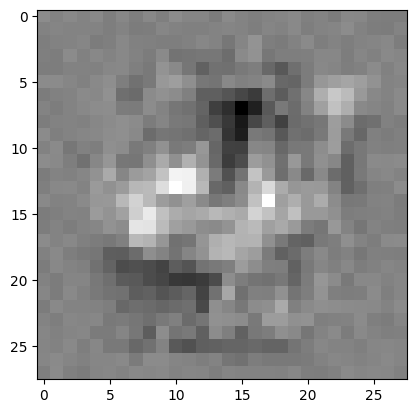

A época: 51/100, tem perda de 0.1188133955001831 e acurácia de: 0.984


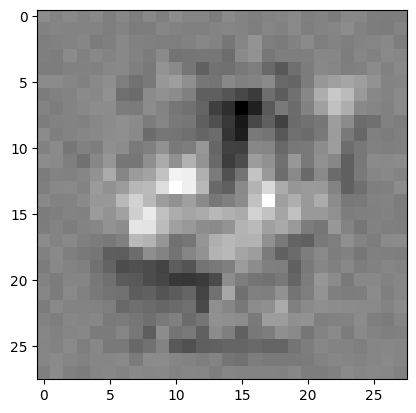

A época: 52/100, tem perda de 0.11854124814271927 e acurácia de: 0.984


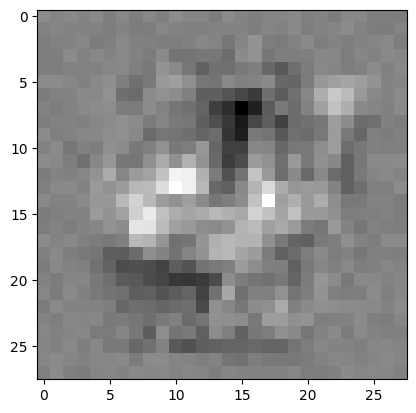

A época: 53/100, tem perda de 0.11827021837234497 e acurácia de: 0.985


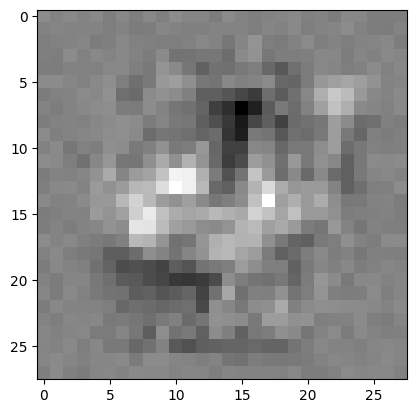

A época: 54/100, tem perda de 0.11800028383731842 e acurácia de: 0.985


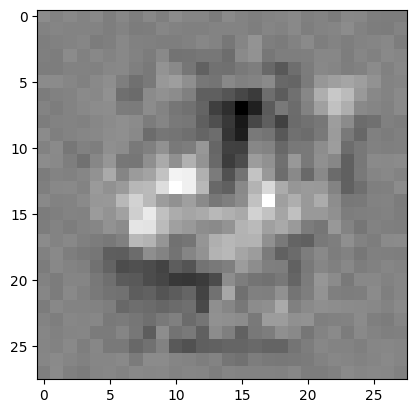

A época: 55/100, tem perda de 0.11773145943880081 e acurácia de: 0.985


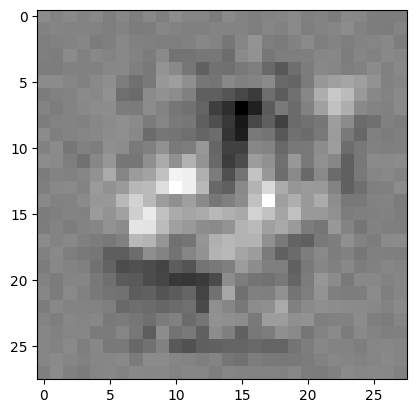

A época: 56/100, tem perda de 0.11746375262737274 e acurácia de: 0.986


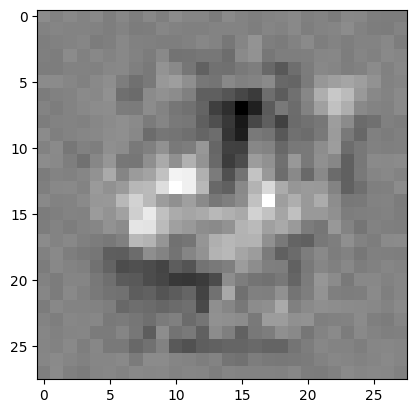

A época: 57/100, tem perda de 0.11719710379838943 e acurácia de: 0.986


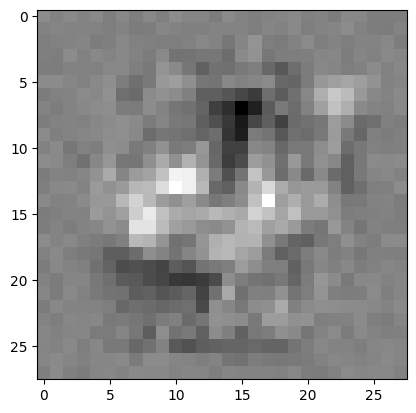

A época: 58/100, tem perda de 0.11693156510591507 e acurácia de: 0.986


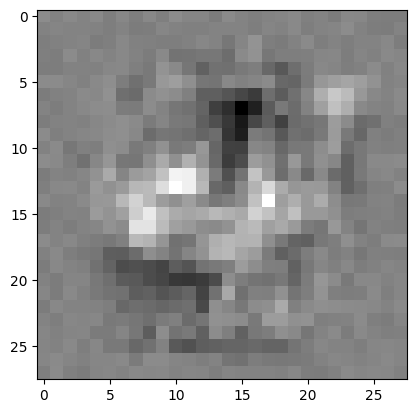

A época: 59/100, tem perda de 0.11666710674762726 e acurácia de: 0.986


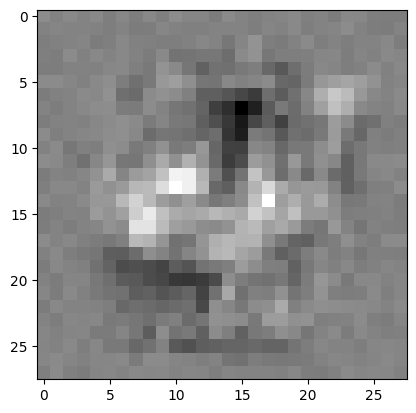

A época: 60/100, tem perda de 0.11640371382236481 e acurácia de: 0.986


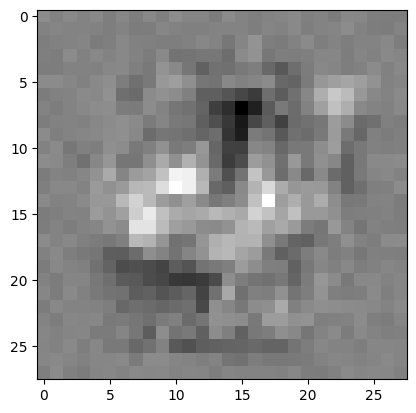

A época: 61/100, tem perda de 0.11614138633012772 e acurácia de: 0.986


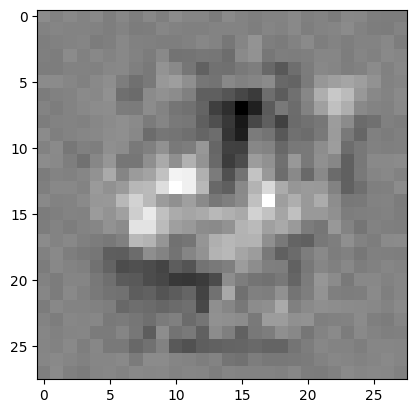

A época: 62/100, tem perda de 0.11588010936975479 e acurácia de: 0.987


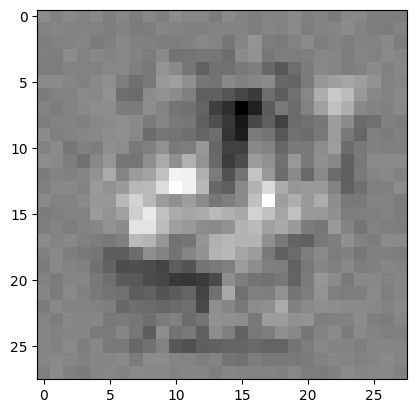

A época: 63/100, tem perda de 0.11561990529298782 e acurácia de: 0.987


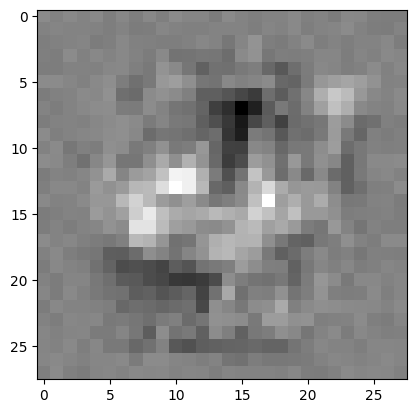

A época: 64/100, tem perda de 0.11536072194576263 e acurácia de: 0.987


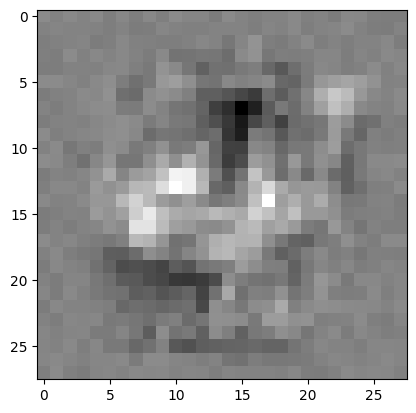

A época: 65/100, tem perda de 0.11510259658098221 e acurácia de: 0.987


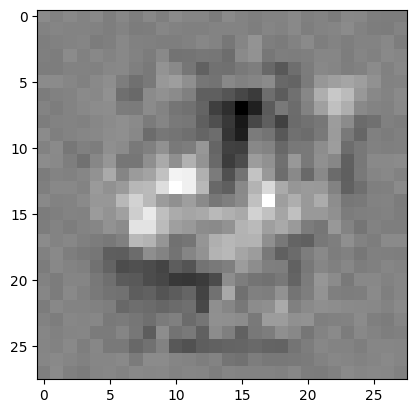

A época: 66/100, tem perda de 0.11484552174806595 e acurácia de: 0.987


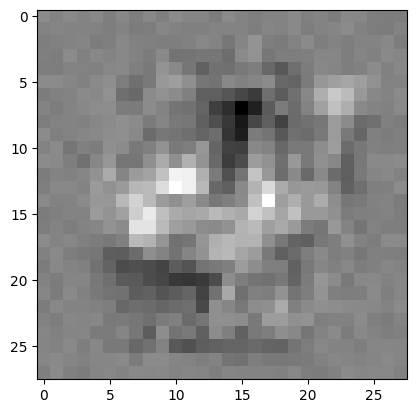

A época: 67/100, tem perda de 0.11458944529294968 e acurácia de: 0.987


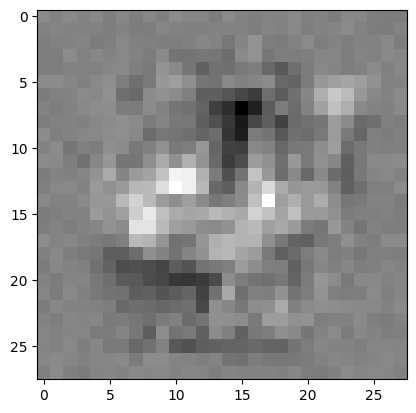

A época: 68/100, tem perda de 0.11433441936969757 e acurácia de: 0.987


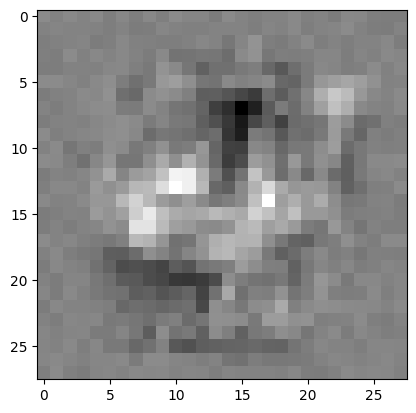

A época: 69/100, tem perda de 0.11408038437366486 e acurácia de: 0.987


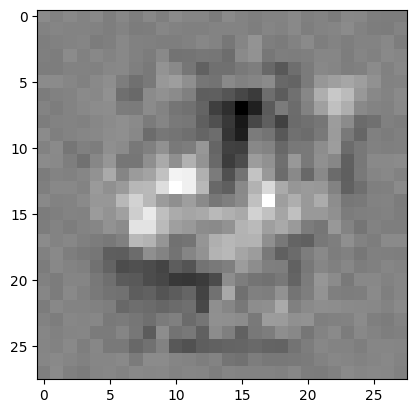

A época: 70/100, tem perda de 0.11382738500833511 e acurácia de: 0.987


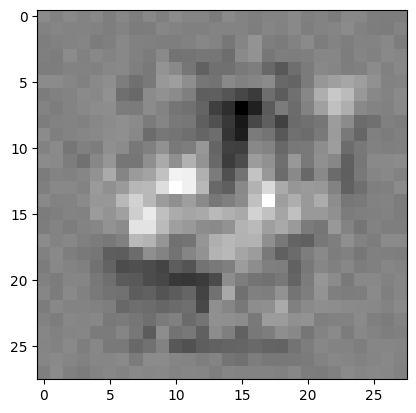

A época: 71/100, tem perda de 0.11357538402080536 e acurácia de: 0.987


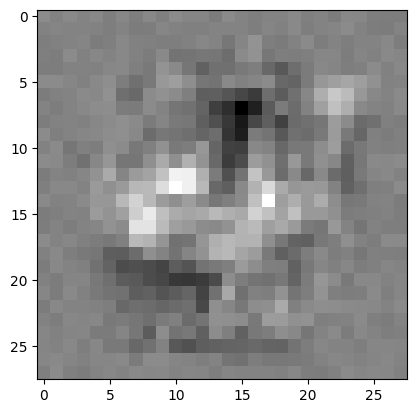

A época: 72/100, tem perda de 0.11332438141107559 e acurácia de: 0.987


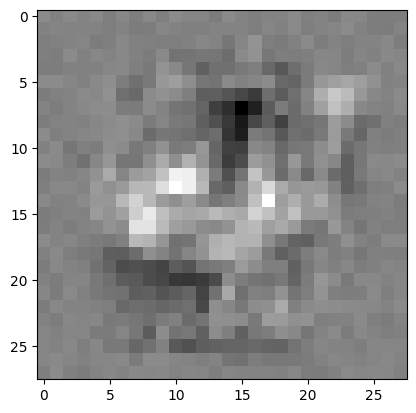

A época: 73/100, tem perda de 0.11307436972856522 e acurácia de: 0.987


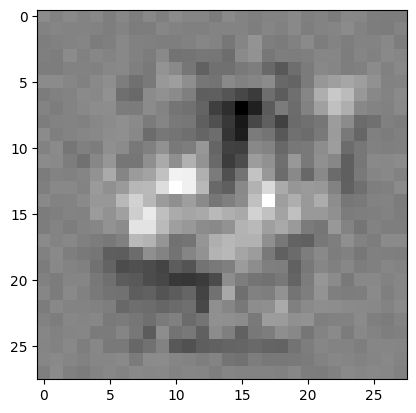

A época: 74/100, tem perda de 0.11282534897327423 e acurácia de: 0.987


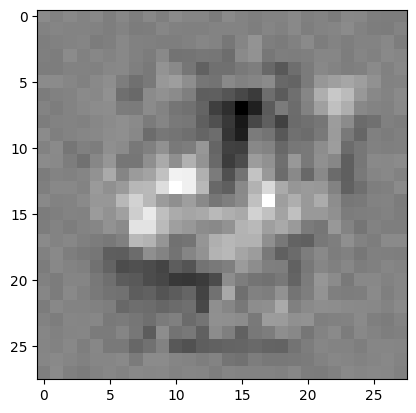

A época: 75/100, tem perda de 0.11257731914520264 e acurácia de: 0.987


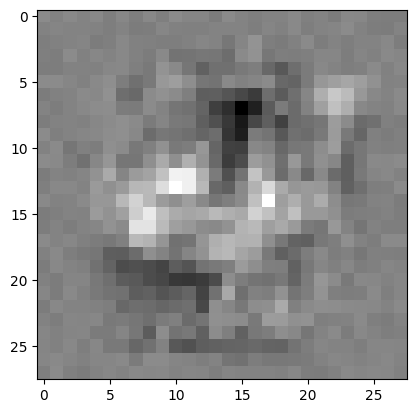

A época: 76/100, tem perda de 0.11233025789260864 e acurácia de: 0.988


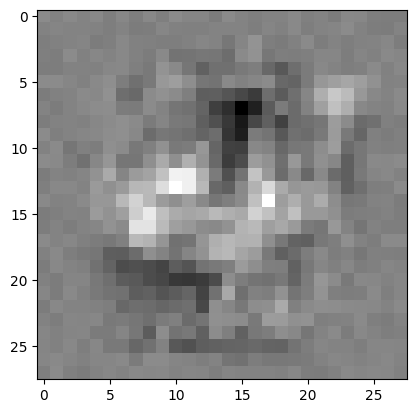

A época: 77/100, tem perda de 0.11208417266607285 e acurácia de: 0.989


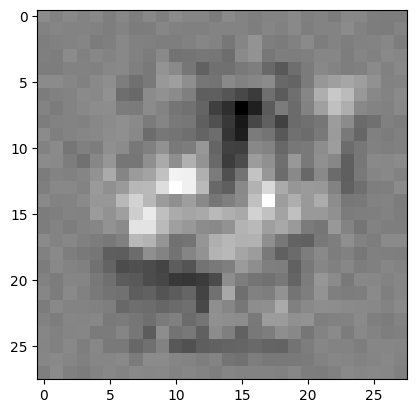

A época: 78/100, tem perda de 0.11183904111385345 e acurácia de: 0.989


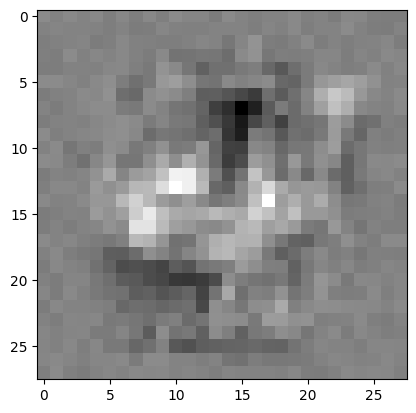

A época: 79/100, tem perda de 0.11159488558769226 e acurácia de: 0.989


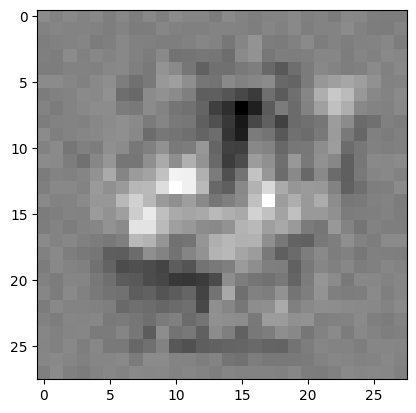

A época: 80/100, tem perda de 0.11135168373584747 e acurácia de: 0.989


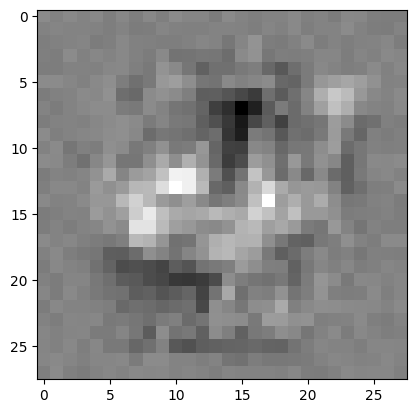

A época: 81/100, tem perda de 0.11110944300889969 e acurácia de: 0.989


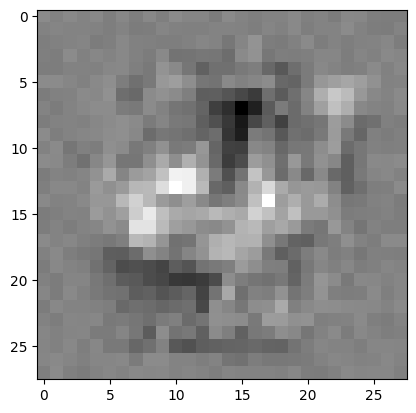

A época: 82/100, tem perda de 0.11086813360452652 e acurácia de: 0.99


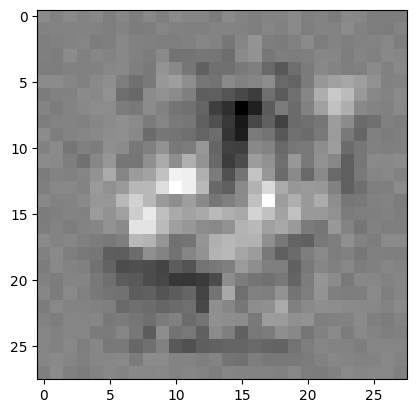

A época: 83/100, tem perda de 0.11062777787446976 e acurácia de: 0.99


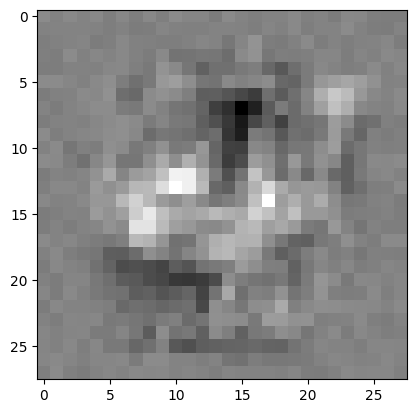

A época: 84/100, tem perda de 0.11038834601640701 e acurácia de: 0.991


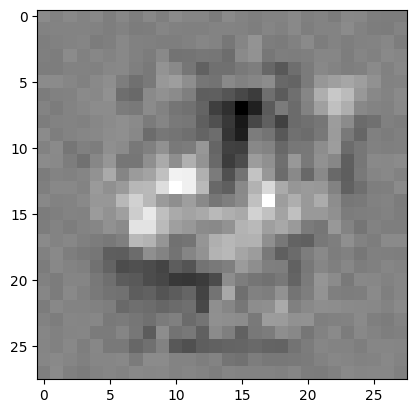

A época: 85/100, tem perda de 0.1101498231291771 e acurácia de: 0.991


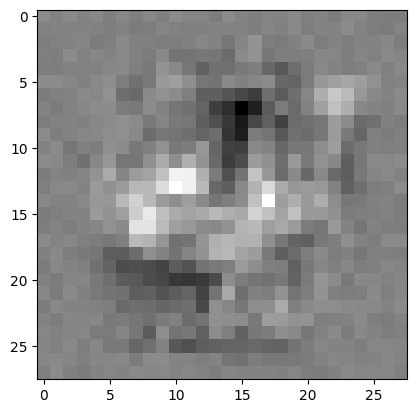

A época: 86/100, tem perda de 0.10991225391626358 e acurácia de: 0.991


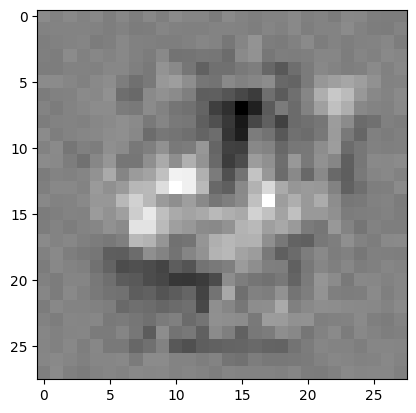

A época: 87/100, tem perda de 0.10967560857534409 e acurácia de: 0.991


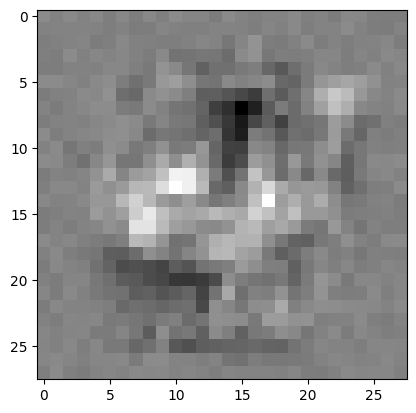

A época: 88/100, tem perda de 0.10943984240293503 e acurácia de: 0.991


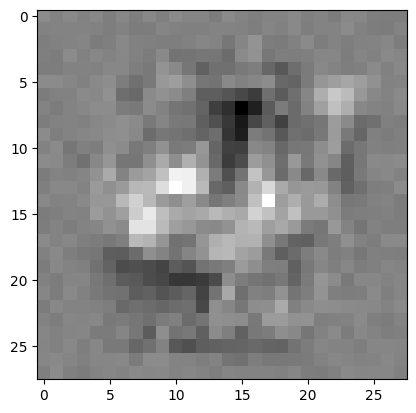

A época: 89/100, tem perda de 0.10920502245426178 e acurácia de: 0.991


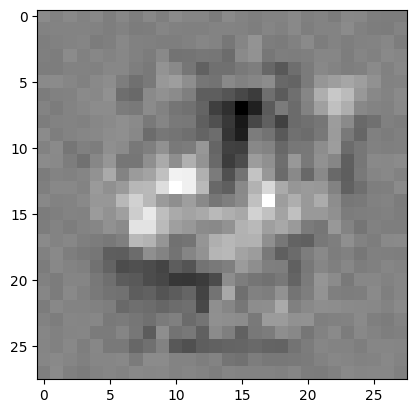

A época: 90/100, tem perda de 0.10897108167409897 e acurácia de: 0.991


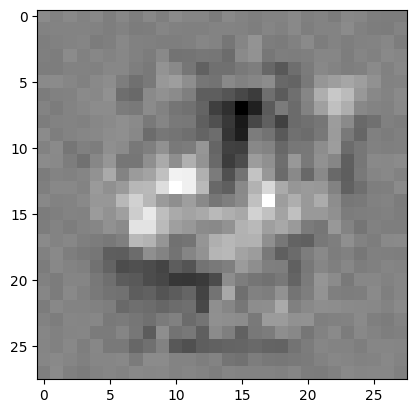

A época: 91/100, tem perda de 0.10873804241418839 e acurácia de: 0.991


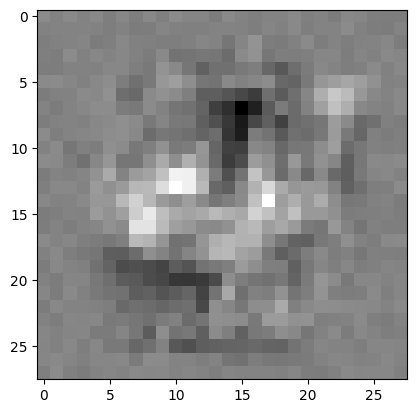

A época: 92/100, tem perda de 0.10850591212511063 e acurácia de: 0.991


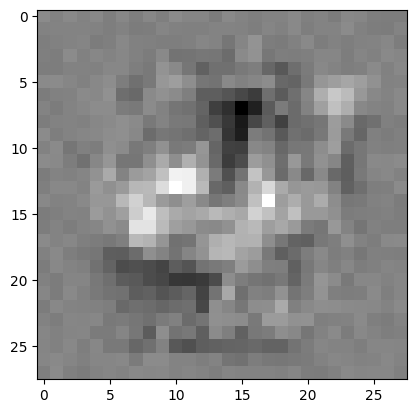

A época: 93/100, tem perda de 0.1082746759057045 e acurácia de: 0.991


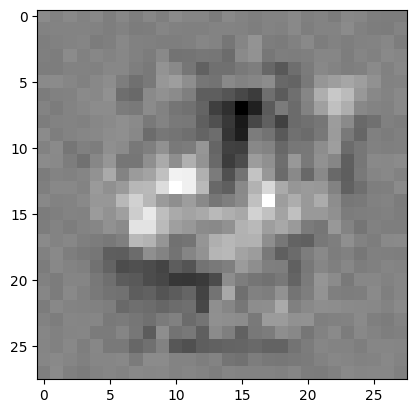

A época: 94/100, tem perda de 0.10804431140422821 e acurácia de: 0.991


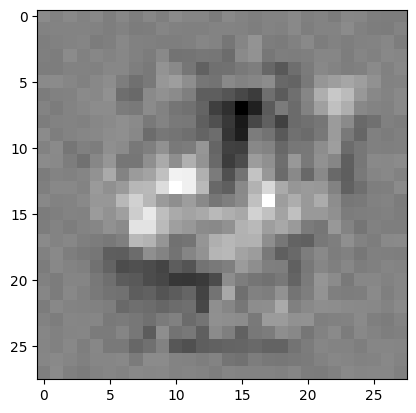

A época: 95/100, tem perda de 0.10781481862068176 e acurácia de: 0.991


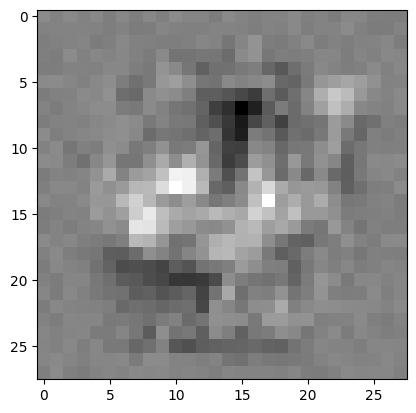

A época: 96/100, tem perda de 0.10758621990680695 e acurácia de: 0.991


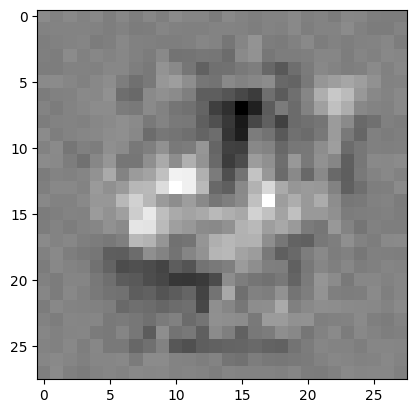

A época: 97/100, tem perda de 0.10735847800970078 e acurácia de: 0.991


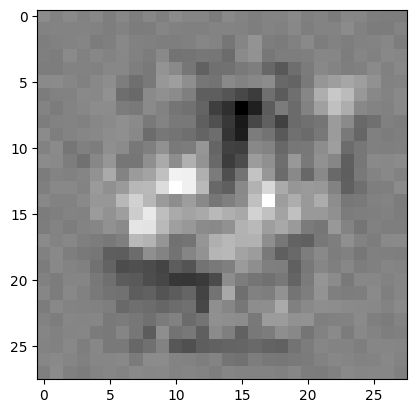

A época: 98/100, tem perda de 0.10713160037994385 e acurácia de: 0.991


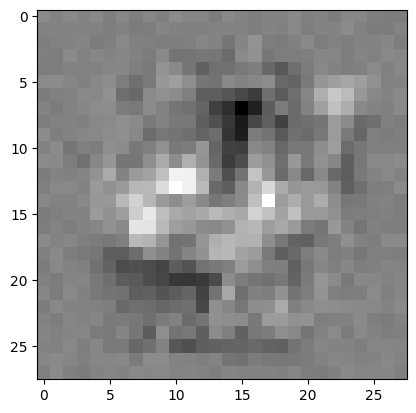

A época: 99/100, tem perda de 0.10690559446811676 e acurácia de: 0.991


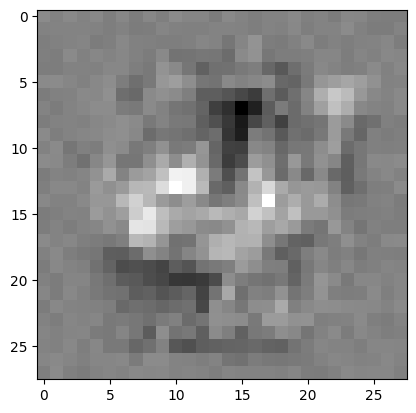

A época: 100/100, tem perda de 0.10668044537305832 e acurácia de: 0.991


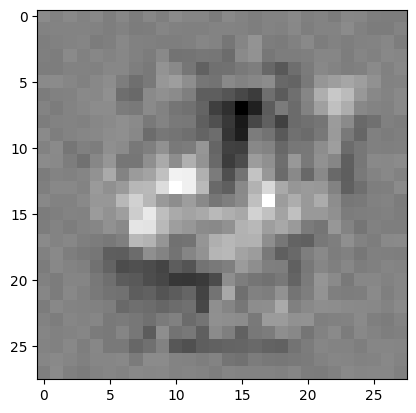

In [92]:
import numpy

losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9 - Score
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()



    print(f"A época: {i+1}/{epochs}, tem perda de {loss.data} e acurácia de: {accuracy}")

    weights = model.state_dict()['weight']
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()



<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?

R.: 1000 amostra de 28 * 28 pixels (1000, 28, 28)
2. Qual é o shape da saída da rede?

R.: 1000 amostras divididas em 10 classes (0 a 9)
3. Qual é o número total de parâmetros da rede, incluindo o bias?

R.: Parametros: (28 * 28 * 10)+10(de bias) = 7850

# Aprendizados

Quanto mais amostras foram usadas, maior será a acurácia do modelo.